In [6]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.callbacks import EarlyStopping



In [7]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train, x_test = np.expand_dims(x_train, -1), np.expand_dims(x_test, -1)


x_train = x_train[:10000]
x_test = x_test[:2000]


In [8]:
noise_factor = 0.4
x_train_noisy = np.clip(x_train + noise_factor * np.random.randn(*x_train.shape), 0., 1.)
x_test_noisy = np.clip(x_test + noise_factor * np.random.randn(*x_test.shape), 0., 1.)

# Build lighter autoencoder
def fast_autoencoder():
    input_img = layers.Input(shape=(28, 28, 1))
    x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    encoded = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)

    x = layers.UpSampling2D((2, 2))(encoded)
    decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    return models.Model(input_img, decoded)

autoencoder = fast_autoencoder()
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')


In [9]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = autoencoder.fit(
    x_train_noisy, x_train,
    epochs=15,
    batch_size=64,
    shuffle=True,
    validation_data=(x_test_noisy, x_test),
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - loss: 0.5550 - val_loss: 0.3335
Epoch 2/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - loss: 0.3236 - val_loss: 0.3168
Epoch 3/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 55ms/step - loss: 0.3102 - val_loss: 0.3096
Epoch 4/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - loss: 0.3041 - val_loss: 0.3067
Epoch 5/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - loss: 0.2996 - val_loss: 0.3056
Epoch 6/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - loss: 0.3017 - val_loss: 0.3045
Epoch 7/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - loss: 0.3002 - val_loss: 0.3038
Epoch 8/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - loss: 0.2983 - val_loss: 0.3032
Epoch 9/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - loss: 0.2968 - val_loss: 0.3027
Epoch 10/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - loss: 0.2970 - val_loss: 0.3025
Epoch 11/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - loss: 0.2988 - val_loss: 0.3024
Epoch 12/15
157/157 ━━━━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


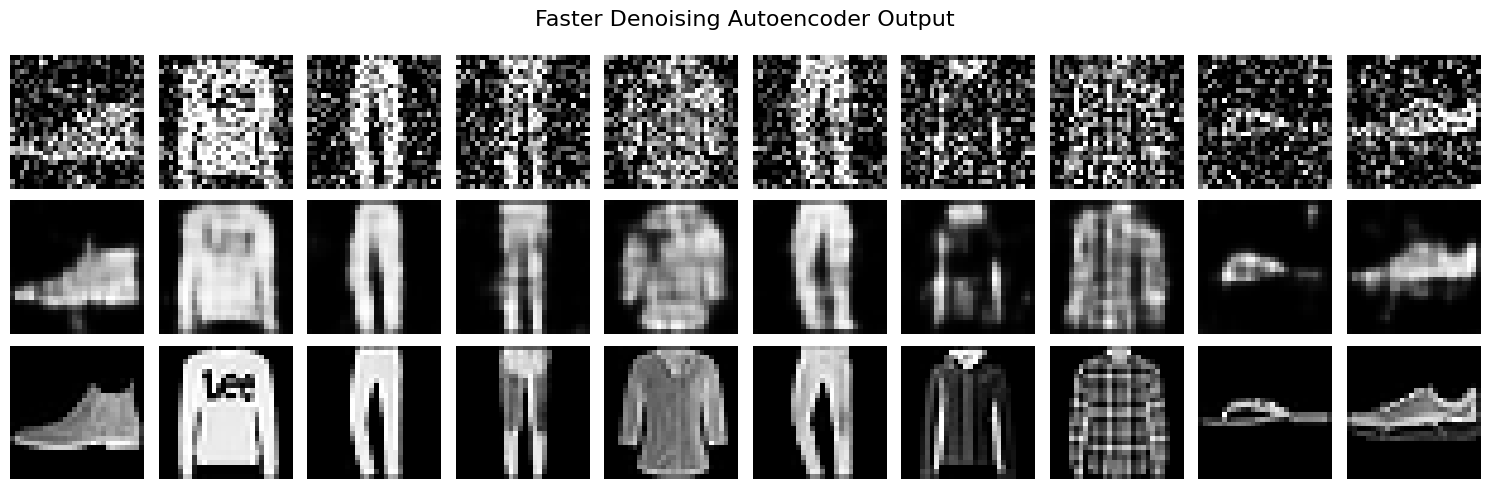

In [10]:
decoded_imgs = autoencoder.predict(x_test_noisy[:10])

plt.figure(figsize=(15, 5))
for i in range(10):
    # Noisy
    plt.subplot(3, 10, i + 1)
    plt.imshow(x_test_noisy[i].squeeze(), cmap='gray')
    plt.axis('off')
    # Denoised
    plt.subplot(3, 10, i + 11)
    plt.imshow(decoded_imgs[i].squeeze(), cmap='gray')
    plt.axis('off')
    # Original
    plt.subplot(3, 10, i + 21)
    plt.imshow(x_test[i].squeeze(), cmap='gray')
    plt.axis('off')

plt.suptitle("Faster Denoising Autoencoder Output", fontsize=16)
plt.tight_layout()
plt.show()

In [11]:
def fast_autoencoder():
    input_img = layers.Input(shape=(28, 28, 1))
    x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    encoded = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)

    x = layers.UpSampling2D((2, 2))(encoded)
    decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = models.Model(input_img, decoded)
    encoder = models.Model(input_img, encoded)
    return autoencoder, encoder


In [12]:
autoencoder, encoder = fast_autoencoder()
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


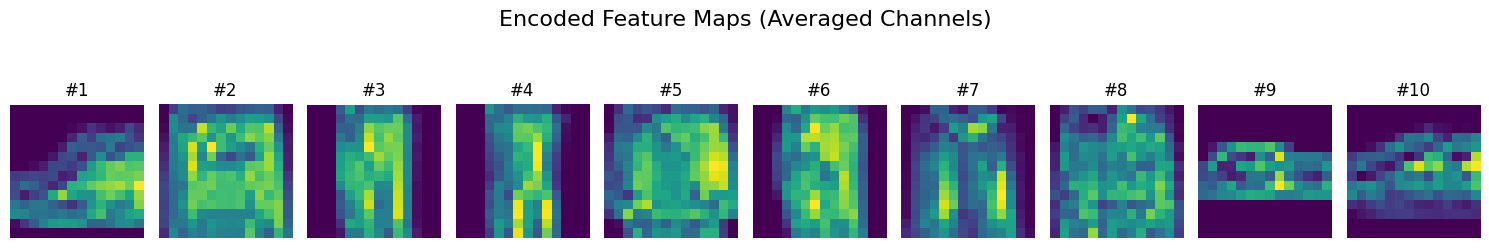

In [13]:
# Generate encoded outputs for 10 test samples
encoded_imgs = encoder.predict(x_test[:10])

# Visualize encoded feature maps (mean across channels)
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(15, 3))
for i in range(10):
    ax = plt.subplot(1, 10, i + 1)
    # Reduce 3D (height, width, channels) to 2D by averaging over channels
    feature_map = np.mean(encoded_imgs[i], axis=-1)
    plt.imshow(feature_map, cmap='viridis')
    plt.title(f"#{i+1}")
    plt.axis("off")

plt.suptitle("Encoded Feature Maps (Averaged Channels)", fontsize=16)
plt.tight_layout()
plt.show()


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


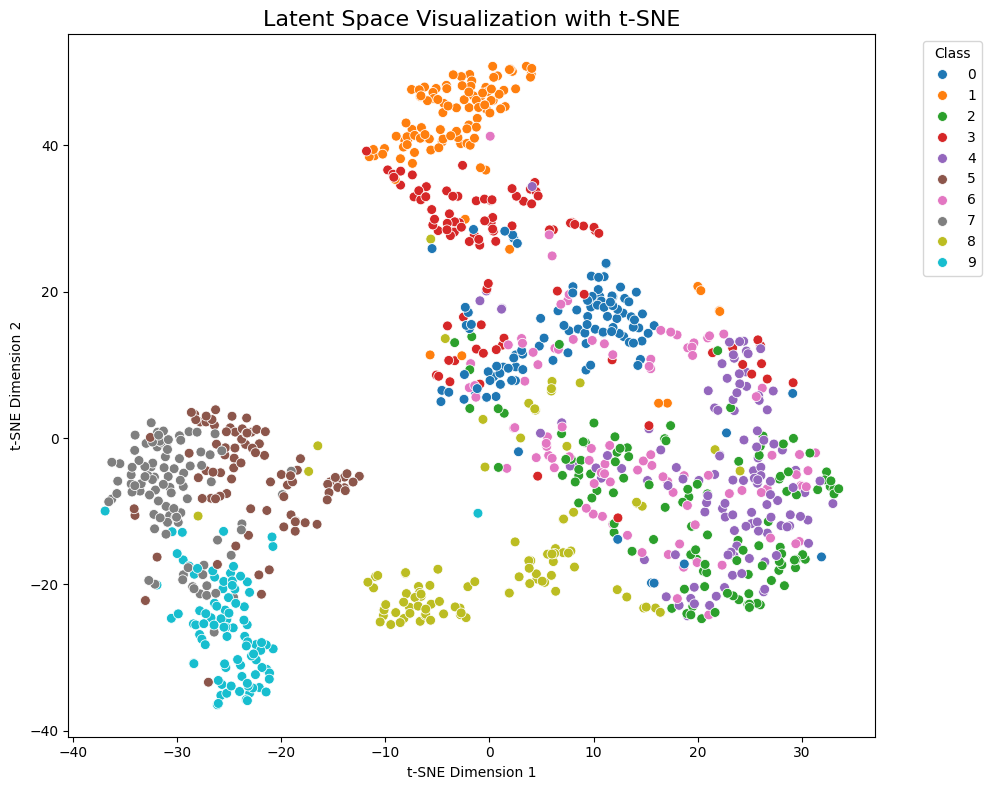

In [16]:
import seaborn as sns

n_samples = 1000
encoded_imgs = encoder.predict(x_test[:n_samples])

encoded_flat = encoded_imgs.reshape(n_samples, -1)

tsne = TSNE(n_components=2, random_state=42, perplexity=30, init='pca')
tsne_result = tsne.fit_transform(encoded_flat)

plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=tsne_result[:, 0], y=tsne_result[:, 1],
    hue=_[:n_samples],
    palette='tab10', legend='full', s=50
)
plt.title('Latent Space Visualization with t-SNE', fontsize=16)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(title='Class', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

**Summary**

The code implements a lightweight convolutional denoising autoencoder on the Fashion MNIST dataset. Noisy inputs are created by adding Gaussian noise, and the model is trained to reconstruct clean images. After training with early stopping, the denoised results are visualized alongside noisy and original images. Encoded feature maps are extracted and visualized, and t-SNE is applied to the flattened latent representations to explore the structure of the learned feature space. Key fixes include proper label handling and correcting function and variable naming errors.




